# Durable Consumption Model

This notebooks shows you how to use the tools of the **consav** package to solve a **durable consumption model** with either

1. **vfi**: standard value function iteration (written in C++)
2. **nvfi**: nested value function iteration (writen in Python, or **nvfi_cpp** is written i C++)
3. **negm**: nested endogenous grid point method (writen in Python, or **negm_cpp** is written i C++)

The implemented solution methods are explained in detail in [A Guide to Solve Non-Convex Consumption-Saving Models](https://doi.org/10.1007/s10614-020-10045-x).

**Computer used for timings:** Windows 10 computer with 2x Intel(R) Xeon(R) Gold 6254 3.10 GHz CPUs (18 cores, 36 logical processes each) and 768 GB of RAM.

## Model equations

The **states** are:

1. the persistent component of income, $p_t$
2. stock of the durable good, $n_t$
3. cash-on-hand, $m_t$

The **choices** are:

1. durable consumption, $d_t$
2. non-durable consumption, $c_t$

**Utility** is CRRA over a Cobb-Douglas aggregate:

$$ u(c_{t},d_{t})=\frac{(c_{t}^{\alpha}(d_{t}+\underline{d})^{1-\alpha})^{1-\rho}}{1-\rho} $$

**Income** follows a persistent-transitory process:

$$
\begin{aligned}
p_{t+1}&=\psi_{t+1}p_{t}^{\lambda},\,\,\,\log\psi_{t+1}\sim\mathcal{N}(-0.5\sigma_{\psi}^{2},\sigma_{\psi}^{2}) \\ y_{t+1}&=\xi_{t+1}p_{t+1},\,\,\,\log\xi_{t+1}\sim\mathcal{N}(-0.5\sigma_{\xi}^{2},\sigma_{\xi}^{2})
\end{aligned} 
$$

The household **cannot borrow** and the **interest rate** on savings is $r$. Adjusting the stock of durables is subject to a **proportional adjustment cost** $\tau$ and **durables depreciates** with a rate of $\delta$.

$$ n_{t+1}=(1-\delta)d_{t} $$

The **bellman equation** is

$$
\begin{aligned}
v_{t}(p_{t},n_{t},m_{t})&=\max\{v_{t}^{keep}(p_{t},n_{t},m_{t}),v_{t}^{adj.}(p_{t},x_{t})\}\\&\text{s.t.}&\\x_{t}&=&m_{t}+(1-\tau)n_{t}
\end{aligned} 
$$

 where
 
$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+\beta\mathbb{E}_{t}[v_{t+1}(p_{t+1},n_{t+1},m_{t+1})]\\&\text{s.t.}&\\
a_{t}&= m_{t}-c_{t}\\
m_{t+1}&= (1+r)a_{t}+y_{t+1}\\
n_{t+1}&= (1-\delta)n_{t}\\
a_{t}&\geq 0
\end{aligned} 
$$

and
 
$$
\begin{aligned}
v_{t}^{adj.}(p_{t},x_{t})&= \max_{c_{t},d_{t}}u(c_{t},d_{t})+\beta\mathbb{E}_{t}[v_{t+1}(p_{t+1},n_{t+1},m_{t+1})]\\&\text{s.t.}&\\
a_{t}&= x_{t}-c_{t}-d_{t}\\
m_{t+1}&= (1+r)a_{t}+y_{t+1}\\ 
n_{t+1}&= (1-\delta)n_{t}\\
a_{t}&\geq 0
\end{aligned} 
$$


## Overview

The model solved in this notebook is written in **DurableConsumptionModelModel.py**. 

It provides a class called **DurableConsumptionModelClass** inheriting its basic interface from the **ModelClass**. 

A short **overview** of the interface is:

1. The class must have a **name** and must contain **three central methods**: 

    1. `settings()` Choose fundamental settings (called *first* when initializing).
    
        1. `namespaces (list of str)`: In addition to `.par`, `.sol`, `.sim`, each element will be available as an attribute (can be used in numba jitted functions).
        2. `other_attrs (list of str)`: Other attributes to be saved (can *not* be used in numba jitted functions).
        3. `savefolder (str)`: Folder to save the model in.
        4. `not_float list of str)`: List of non-float elements in the namespaces (ensures safe type inference).<br><br>
        
    2. `setup()`: Set baseline parameters (called *second* when initializing).
    3. `allocate()`: Create grids and allocate solution and simulation memory (called *third* when initializing).

2. **Type-inference:** When initializing the model the `settings()`, `setup()` and `allocate()` methods are called, and the types of all variables in the namespaces are inferred. Results can be seen by `print(model)`. *Types and number of dimensions in arrays must not change afterwards.* 
3. The **solve()** method solves the model
4. The **simulate()** method simulates the model
5. The **save()** method saves the model naming it **savefolder/name**
6. The **copy()** makes a deep copy of the model

In addition to **DurableConsumptionModel.py**, this folder contains the following files:

1. **last_period.py**: calculate consumption and value function in last period
2. **utility.py**: utility function and marginal utility function
3. **trans.py**: state transition functions
4. **post_decision.py**: calcualte $w$ and $q$
5. **nvfi.py**: solve with nested value function iteration
6. **negm.py**: solve with the nested endogenous grid method
7. **simulate.py**: simulate for all solution methods
8. **figs.py**: plot figures
9. **tabs.py**: prints tables in .tex files

The functions in these modules are loaded in **DurableConsumptionModel.py**.

The folder **cppfuncs** contains C++ functions not used in this notebook.

# Setup

In [25]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Choose number of threads in numba

In [2]:
import numba as nb
nb.set_num_threads(4)

# Settings

Choose number of periods to solve:

In [11]:
T = 100

# NVFI - nested value function iteration

Define the **post-decision value function** as

$$ w_{t}(p_{t},n_{t},a_{t}) = \beta \mathbb{E}_{t}[v_{t+1}(m_{t+1},n_{t+1},p_{t+1})] $$

The **keeper problem** can then be written:

$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+ w_{t}(p_{t},n_{t},a_{t})]\\&\text{s.t.}&\\a_{t}&=&m_{t}-c_{t}\geq0
\end{aligned}
$$

The **adjuster problem** can further be written:

$$
\begin{aligned}
v_{t}^{adj.}(x_{t})&=\max_{d_{t}}v_{t}^{keep}(p_{t},d_{t},n_{t})\\&\text{s.t.}&\\m_{t}&=&x_{t}-d_{t}
\end{aligned}
$$

**NVFI** solves this reformulated problem.

In [12]:
model_nvfi = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'nvfi','T':T,'do_print':True})
print(model_nvfi)

Modelclass: DurableConsumptionModelClass
Name: example_negm

namespaces: ['sim', 'par', 'sol']
other_attrs: []
savefolder: saved
cpp_filename: None

sim:
 p0 = ndarray with shape = (1000,) [dtype: float64]
 d0 = ndarray with shape = (1000,) [dtype: float64]
 a0 = ndarray with shape = (1000,) [dtype: float64]
 utility = ndarray with shape = (1000,) [dtype: float64]
 p = ndarray with shape = (100, 1000) [dtype: float64]
 m = ndarray with shape = (100, 1000) [dtype: float64]
 n = ndarray with shape = (100, 1000) [dtype: float64]
 discrete = ndarray with shape = (100, 1000) [dtype: int64]
 d = ndarray with shape = (100, 1000) [dtype: float64]
 c = ndarray with shape = (100, 1000) [dtype: float64]
 a = ndarray with shape = (100, 1000) [dtype: float64]
 euler_error = ndarray with shape = (99, 1000) [dtype: float64]
 euler_error_c = ndarray with shape = (99, 1000) [dtype: float64]
 euler_error_rel = ndarray with shape = (99, 1000) [dtype: float64]
 psi = ndarray with shape = (100, 1000) [dtyp

In [24]:
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()
model_nvfi.save()

numba precompiled in 27.4 secs
 t = 74 solved in 0.1 secs
  w computed in 0.4 secs
  solved keeper problem in 0.9 secs
  solved adjuster problem in 0.0 secs
 t = 73 solved in 1.4 secs
  w computed in 0.3 secs
  solved keeper problem in 0.9 secs
  solved adjuster problem in 0.0 secs
 t = 72 solved in 2.7 secs
  w computed in 0.3 secs
  solved keeper problem in 0.9 secs
  solved adjuster problem in 0.0 secs
 t = 71 solved in 3.9 secs
  w computed in 0.3 secs
  solved keeper problem in 0.9 secs
  solved adjuster problem in 0.0 secs
 t = 70 solved in 5.1 secs
  w computed in 0.3 secs
  solved keeper problem in 0.8 secs
  solved adjuster problem in 0.0 secs
 t = 69 solved in 6.3 secs
  w computed in 0.2 secs
  solved keeper problem in 0.9 secs
  solved adjuster problem in 0.0 secs
 t = 68 solved in 7.4 secs
  w computed in 0.3 secs
  solved keeper problem in 0.8 secs
  solved adjuster problem in 0.0 secs
 t = 67 solved in 8.6 secs
  w computed in 0.5 secs
  solved keeper problem in 0.9 secs

**Plot** interactive decision functions:

In [25]:
model_nvfi.decision_functions()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

**Plot** life-cycle profiles:

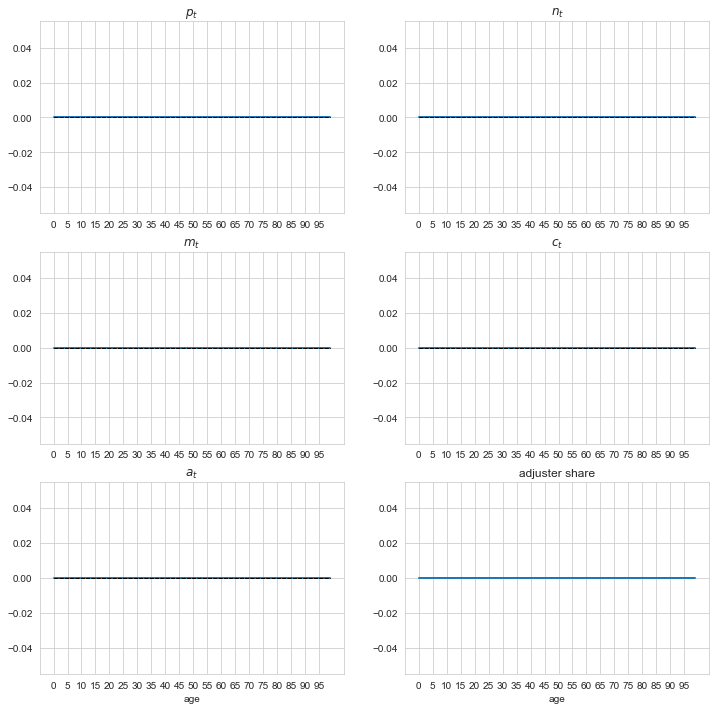

In [18]:
model_nvfi.lifecycle()

# NEGM - nested endogenous grid method

Define the **post-decision marginal value of cash:**

$$
\begin{aligned}
q_{t}(p_{t},d_{t},a_{t})&=\beta R\mathbb{E}_{t}[u_{c}(c_{t+1},d_{t+1})]\\
&=&\beta R\mathbb{E}_{t}[\alpha c_{t+1}^{\alpha(1-\rho)-1}d_{t+1}^{(1-\alpha)(1-\rho)}]
\end{aligned}
$$

Note that all optimal interior consumption choices must satisfy the **Euler-equation**

$$
\begin{aligned}
u_{c}(c_{t},d_{t})=\alpha c_{t}^{\alpha(1-\rho)-1}d_{t}^{(1-\alpha)(1-\rho)}&=q(p_{t},d_{t},a_{t})
\end{aligned}
$$

This implies that we have an analytical mapping from the post-decision space $(p_t,d_t,a_t)$ to consumption and cash-on-hand $(c_t,m_t)$:

$$
\begin{aligned}
c_{t} &=\frac{1}{\alpha}\left(\frac{q(a_{t},d_{t},p_{t})}{d_{t}^{(1-\alpha)(1-\rho)}}\right)^{\alpha(1-\rho)-1}
\\
m_{t} &= a_{t}+c_{t}
\end{aligned}
$$

**NEGM** uses this mapping (and an upperenvelope algorithm) to solve the keeper problem much faster.

In [26]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','T':T,'do_print':True})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()
model_negm.save()

numba precompiled in 29.7 secs
 t = 99 solved in 0.0 secs
  w computed in 0.6 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 98 solved in 0.7 secs
  w computed in 0.5 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 97 solved in 1.3 secs
  w computed in 0.5 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 96 solved in 1.9 secs
  w computed in 0.5 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 95 solved in 2.5 secs
  w computed in 0.5 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 94 solved in 3.1 secs
  w computed in 0.5 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 93 solved in 3.7 secs
  w computed in 0.5 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 92 solved in 4.3 secs
  w computed in 0.5 secs
  solved keeper problem in 0.1 secs

**Plot** interactive decision functions:

In [20]:
model_negm.decision_functions()

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

**Plot** life-cycle profiles:

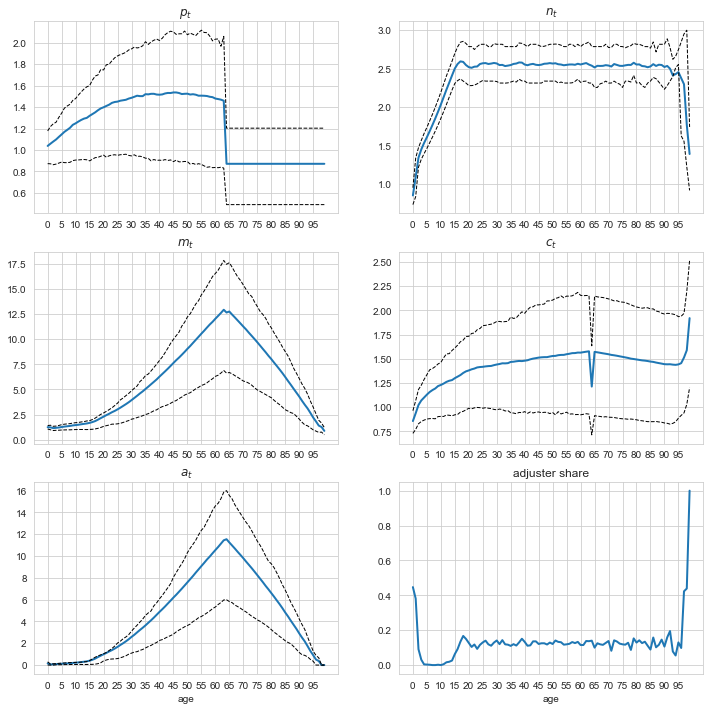

In [27]:
model_negm.lifecycle()

# Compare life-cycles from NVFI and NEGM

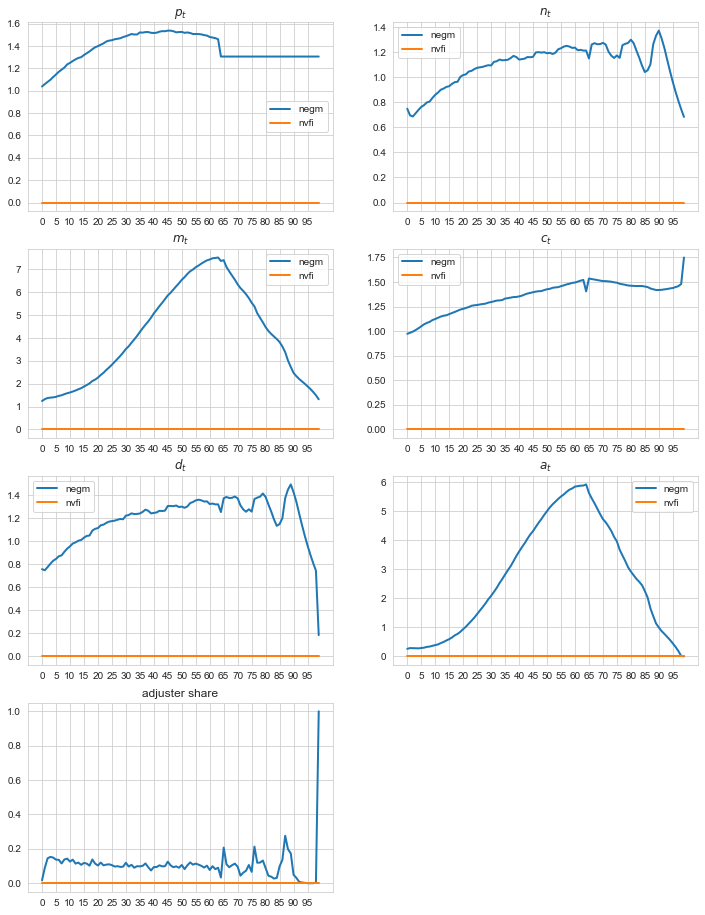

In [16]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')

# Compare life-cycle profiles with VFI

In [31]:
model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','T':T,'do_print':True})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()
model_vfi.save()

numba precompiled in 55.9 secs
 t = 74 solved in 0.1 secs
  w computed in 0.6 secs
  solved keeper problem in 39.9 secs
  solved adjuster problem in 1.9 secs
 t = 73 solved in 42.5 secs
  w computed in 0.6 secs
  solved keeper problem in 36.4 secs
  solved adjuster problem in 2.0 secs
 t = 72 solved in 81.5 secs
  w computed in 0.5 secs


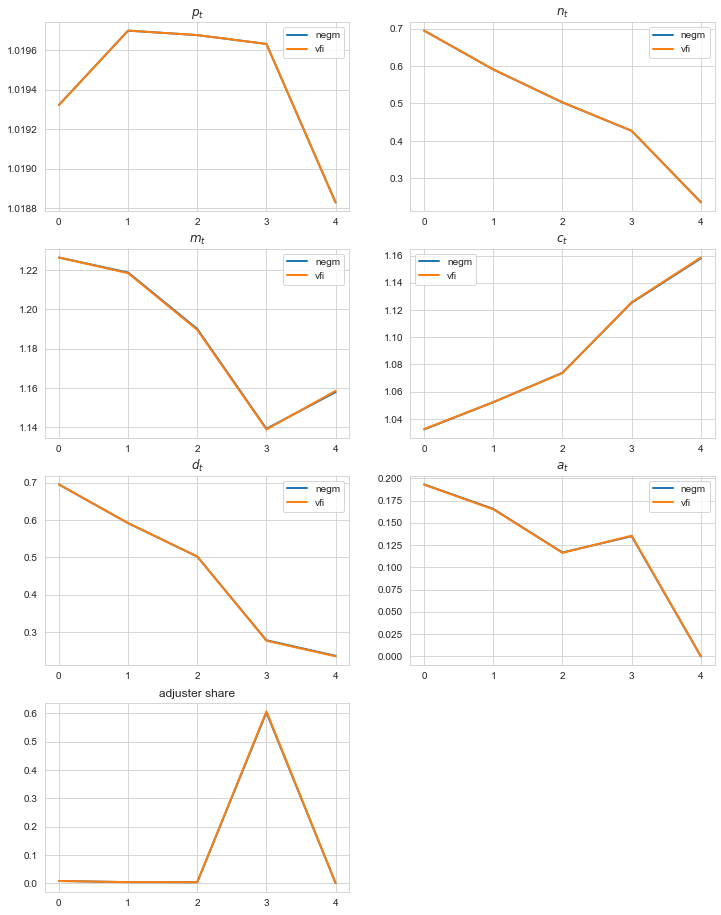

In [13]:
lifecycle_compare(model_negm,'negm',model_vfi,'vfi')